# Introducci√≥n

En el presente documento se realizan un ajustes de regresi√≥n lineal a partir de datos de cierta ciudad obtenidos en un estudio  que considera que el consumo de agua [m$^2$/mes] est√° relacionado con el consumo de energ√≠a el√©ctrica [kW/h]. 

Durante el proceso de an√°lisis se descubre emp√≠ricamente que los datos originales no satisfacen del todo los supuestos del modelo de regresi√≥n lineal y se realiza una transformaci√≥n para corregir dicha desviaci√≥n. 

El enfoque de este reporte se centra en la comparaci√≥n de los ajustes lineales obtenidos para los datos originales y para los datos transformados, as√≠ como en la realizaci√≥n de inferencias a partir del √∫ltimo ajuste. 

# a) Grafique los datos y comente.

In [1]:
# Importaci√≥n de librer√≠as y configuraciones generales.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

pd.options.display.precision = 2 # Para 2 decimales.

"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Options
params = {'font.family':'STIXGeneral',
          'text.usetex' : True,
          'font.size' : 11,
          #'figure.dpi':100
          }

plt.rcParams.update(params) 
"""

"\n%matplotlib inline\n%config InlineBackend.figure_format = 'retina'\n\n#Options\nparams = {'font.family':'STIXGeneral',\n          'text.usetex' : True,\n          'font.size' : 11,\n          #'figure.dpi':100\n          }\n\nplt.rcParams.update(params) \n"

In [2]:
def get_x_bar(df, x):
    return df[x].mean()

def get_y_bar(df, y):
    return df[y].mean()

def get_S_xx(df, x):
    return ((df[x] - get_x_bar(df, x))**2).sum()

def fit(df, x, y):
    """
    df: DataFrame con la columna del regresor y la columna de la variable respuesta.
    x:  str con el nombre de la columna del regresor.
    y:  str con el nombre de la columna de la variable respuesta.
    """
    x_bar = get_x_bar(df, x) # Promedio de observaciones del regresor.
    y_bar = get_y_bar(df, y) # Promedio de observaciones de la variable respuesta.

    S_xy = (df[y]*(df[x] - x_bar)).sum()
    S_xx = get_S_xx(df, x)

    beta_1 = S_xy/S_xx # Estimador de m√≠nimos cuadrados de la pendiente del modelo de regresi√≥n lineal.
    beta_0 = y_bar - beta_1*x_bar  # Estimador de m√≠nimos cuadrados del intercept del modelo de regresi√≥n lineal.

    y_fit = beta_0 + beta_1*df[x] # Ajuste de regresi√≥n lineal
    y_fit.rename("y_fit", inplace = True)
    
    return y_fit, beta_0, beta_1

def get_SS_res(df, y, y_fitted):
    """
    df:       DataFrame con la columna de la variable respuesta y la columna de la respuesta ajustada.
    y:        str con el nombre de la columna de la variable respuesta.
    y_fitted: str con el nombre de la columna de la respuesta ajustada.
    """
    return sum((df[y] - df[y_fitted])**2)

def get_MS_res(df, y, y_fit):
    n = len(df.index) # N√∫mero de observaciones
    return (1/(n-2))*get_SS_res(df, y, y_fit)

def test_beta_0(df, x, y, y_fit, beta_0, beta_0_test = 0, alpha = 0.05):
    n = len(df.index) # N√∫mero de observaciones
    
    x_bar = get_x_bar(df, x)
    S_xx = get_S_xx(df, x)
    MS_res = get_MS_res(df, y, y_fit)
    
    t_0 = (beta_0 - beta_0_test)/(np.sqrt(MS_res*(1/n + x_bar**2/S_xx)))
    nu = n - 2
    test_statistic = stats.t.ppf(alpha/2, nu)
    p_value = stats.t.cdf(-abs(t_0), nu) + 1-stats.t.cdf(abs(t_0), nu)
    
    if p_value < alpha:
        print("Significancia del ajuste: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" < {alpha} = ùõº, se rechaza la hip√≥tesis nula H_0: ùõΩ_0 = {beta_0_test} \n")
    else:
        print("Significancia del ajuste: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" > {alpha} = ùõº, NO se rechaza la hip√≥tesis nula H_0: ùõΩ_0 = {beta_0_test} \n")
    return t_0, test_statistic, p_value

def test_beta_1(df, x, y, y_fitted, beta_1, beta_1_test = 0, alpha = 0.05):
    n = len(df.index) # N√∫mero de observaciones
    
    S_xx = get_S_xx(df, x)
    MS_res = get_MS_res(df, y, y_fitted)
    
    t_0 = (beta_1 - beta_1_test)/(np.sqrt(MS_res/S_xx))
    nu = n - 2
    test_statistic = stats.t.ppf(alpha/2, nu)
    p_value = stats.t.cdf(-abs(t_0), nu) + 1-stats.t.cdf(abs(t_0), nu)
    
    if p_value < alpha:
        print("Significancia del ajuste: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" > {alpha} = ùõº, se rechaza la hip√≥tesis nula H_0: ùõΩ_1 = {beta_1_test} \n")
    else:
        print("Significancia del ajuste: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" > {alpha} = ùõº, NO se rechaza la hip√≥tesis nula H_0: ùõΩ_1 = {beta_1_test} \n")
    return t_0, test_statistic, p_value

def get_SS_r(df, y, y_fit):
    return sum((df[y_fit] - get_y_bar(df, y))**2)

# No s√© por qu√© la estad√≠stica de prueba de F(alpha, 1, n-2) no es la que deber√≠a ser.

def test_analysis_of_variance(df, y, y_fit, beta_1_test = 0, alpha = 0.05):
    n = len(df.index) # N√∫mero de observaciones
    SS_res = get_SS_res(df, y, y_fit)
    SS_r = get_SS_r(df, y, y_fit)
    
    nu = n - 2
    F_0 = ((SS_r/1)/(SS_res/nu))
    test_statistic = stats.f.ppf(alpha, 1, nu)
    p_value = stats.f.cdf(-abs(F_0), 1, nu) + 1-stats.f.cdf(abs(F_0), 1, nu)
    
    if p_value < alpha:
        print("An√°lisis de varianza: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" > {alpha} = ùõº, se rechaza la hip√≥tesis nula H_0: ùõΩ_1 = {beta_1_test} \n")
    else:
        print("An√°lisis de varianza: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" > {alpha} = ùõº, NO se rechaza la hip√≥tesis nula H_0: ùõΩ_1 = {beta_1_test} \n")
    
    return F_0, test_statistic, p_value

def get_SS_t(df, y):
    return sum((df[y] - get_y_bar(df, y))**2)
    
def get_R_2(df, y, y_fit):
    R_2 = np.round(get_SS_r(df, y, y_fit)/get_SS_t(df, y), 4)
    print(f"El valor de R^2 para este ajuste es {R_2}")
    return R_2


def get_lambda(df, x, y, l_lb = -1, l_ub = 1,  num_l = 9):
    lambdas = np.linspace(l_lb, l_ub, num_l)
    SS_trans_res = []
    for l in lambdas:
        y_trans = box_cox_transformation(df, y, l)
        trans_df = pd.concat([df, y_trans], axis = 1)
        trans_df["y_fit"], _, _ = fit(trans_df, x, "y_trans")
        SS_trans_res.append(get_SS_res(trans_df, "y_trans", "y_fit"))

    min_index = SS_trans_res.index(min(SS_trans_res))
    l = lambdas[min_index]
    classification = [" " for i in range(0,len(lambdas))]
    classification[min_index] = "√ìptimo"

    dictionary = {"$\lambda$": lambdas, "$SC_{{Res}}(\lambda)$": SS_trans_res, "Clasificaci√≥n": classification}
    lambda_df = pd.DataFrame.from_dict(dictionary)
    return lambda_df

def box_cox_transformation(df, y, l):
    n = len(df.index) # N√∫mero de observaciones
    y_dot = (df[y].prod())**(1/n) # Promedio geom√©trico de las observaciones de la variable respuesta
    if l == 0:
        y_trans = y_dot*np.log(df[y])
    else:
        y_trans = (1/(l*y_dot**(l-1)))*(df[y]**l - 1)
    y_trans.rename("y_trans", inplace = True)
    return y_trans

def box_cox_transformation_single_obs(df, y, l, y_0):
    n = len(df.index) # N√∫mero de observaciones
    y_dot = float((df[y].prod())**(1/n)) # Promedio geom√©trico de las observaciones de la variable respuesta
    if l == 0:
        y = y_dot*np.log(y_0)
    else:
        y = (1/(l*y_dot**(l-1)))*(y_0**l - 1)
    return y

def inv_box_cox_transformation_single_obs(df, y, l, y_lambda_0):
    n = len(df.index) # N√∫mero de observaciones
    y_dot = float((df[y].prod())**(1/n)) # Promedio geom√©trico de las observaciones de la variable respuesta
    if l == 0:
        y = np.exp(y_lambda_0/y_dot)
    else:
        y = (l*y_lambda_0*y_dot**(l-1)+1)**(1/l)
    return y

def prediction_CI(df, x, y, y_fit, x_0, beta_0, beta_1, alpha = 0.05, mean = True):
    y_0 = beta_0 + beta_1*x_0
    
    n = len(df.index) # N√∫mero de observaciones
    nu = n - 2
    test_statistic = stats.t.ppf(alpha/2, nu)
    
    x_bar = get_x_bar(df, x)
    S_xx = get_S_xx(df, x)
    MS_res = get_MS_res(df, y, y_fit)
    
    if mean: 
        CI_lb = y_0 - test_statistic*np.sqrt(MS_res*(1/n + (x_0 - x_bar)**2/S_xx))
        CI_ub = y_0 + test_statistic*np.sqrt(MS_res*(1/n + (x_0 - x_bar)**2/S_xx))
    else:
        CI_lb = y_0 - test_statistic*np.sqrt(MS_res*(1 + 1/n + (x_0 - x_bar)**2/S_xx))
        CI_ub = y_0 + test_statistic*np.sqrt(MS_res*(1 + 1/n + (x_0 - x_bar)**2/S_xx))
        
    CI_lb, CI_ub = min(CI_lb, CI_ub), max(CI_lb, CI_ub)
    
    return CI_lb, CI_ub

In [3]:
# Funci√≥n para graficar scatter plot con opci√≥n para incluir o no el ajuste de regresi√≥n lineal.
def scatter_fit_plot(df, x, y, caption, color = "blue", trans = False, **kwargs):
    plt.figure()
    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(x + "\n\n" + caption,fontsize=20)
    plt.ylabel(y, fontsize=20)
    plt.title(y + " vs. " + x, fontsize=20)
    
    if trans: 
        label = "Valores transformados"
    else:
        label = "Valores observados"
    scatter = plt.scatter(df[x], df[y], 
                          c = color, 
                          s = 100, 
                          alpha = 0.6, 
                          label = label)
    
    if "y_fit" in kwargs:
        y_fit = kwargs.get("y_fit")
        
        if "beta_0" in kwargs and "beta_1" in kwargs:
            beta_0 = kwargs.get("beta_0")
            beta_1 = kwargs.get("beta_1")
            
            if beta_1 > 0:
                sign = "+"
            else:
                sign = "-"
            line = plt.plot(df[x], df[y_fit], 
                        c = "#75cd01",
                        label = f"Valores ajustados: \n y = {np.round(beta_0,2)} {sign} {abs(np.round(beta_1,2))}x")
    plt.legend(prop={'size': 15})
    plt.show()

In [4]:
# Leer los datos del archivo `control2.dat` cuyas columnas est√°n separadas por m√∫ltiples espacios.
df = pd.read_csv('control2.dat', sep='\s+')

# A lo largo del doc se alterna entre las etiquetas para tener resultados presentables y c√≥digo legible.
pretty_columns = ["Consumo el√©ctrico [kW/h]", "Consumo de agua [m$^2$/mes]"] # Columnas para display, plot, etc.
working_columns = ["x", "y"] # Columnas para c√≥digo y c√°lculos.

df.columns = ["Observaci√≥n"] + pretty_columns

# Etiquetar las observaciones con las numeraci√≥n provista
df = df.set_index('Observaci√≥n')
"""
df = pd.read_csv('../../..//Datos/propellant.dat', sep='\s+')
df = df.filter(["obs", "edad", "fuerza"])
pretty_columns = ["Consumo el√©ctrico [kW/h]", "Consumo de agua [m$^2$/mes]"] # Columnas para display, plot, etc.
working_columns = ["x", "y"] # Columnas para c√≥digo y c√°lculos.
df.columns = ["Observaci√≥n"] + pretty_columns
df = df.set_index('Observaci√≥n')
display(df)
"""

'\ndf = pd.read_csv(\'../../..//Datos/propellant.dat\', sep=\'\\s+\')\ndf = df.filter(["obs", "edad", "fuerza"])\npretty_columns = ["Consumo el√©ctrico [kW/h]", "Consumo de agua [m$^2$/mes]"] # Columnas para display, plot, etc.\nworking_columns = ["x", "y"] # Columnas para c√≥digo y c√°lculos.\ndf.columns = ["Observaci√≥n"] + pretty_columns\ndf = df.set_index(\'Observaci√≥n\')\ndisplay(df)\n'

In [ ]:
display(df.head())

In [ ]:
# INSERTAR PLOT QUE M√ìNICA COMENT√ì EN LA LLAMADA, ESE ES Figura 1.

<Figure size 432x288 with 0 Axes>

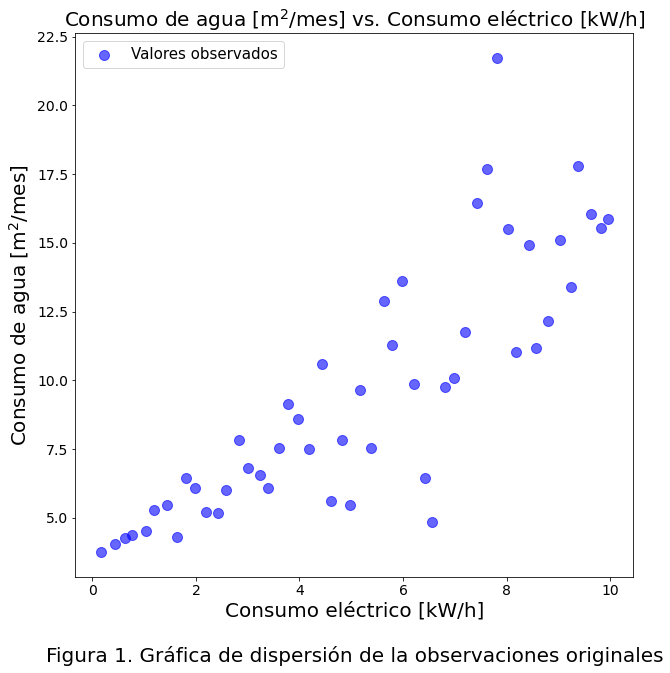

In [5]:
caption = "Figura 1. Gr√°fica de dispersi√≥n de la observaciones originales"
scatter_fit_plot(df, pretty_columns[0], pretty_columns[1], caption)

# b) Ajuste un modelo de regresi√≥n lineal simple sobre los datos sin transformar.

In [6]:
df.columns = working_columns

df["y_fit"], beta_0, beta_1 = fit(df, "x", "y")
pretty_columns = ["Consumo el√©ctrico [kW/h]", 
                  "Consumo de agua [m$^2$/mes]",
                  "Ajuste lineal (respuesta original)"]
df.columns = pretty_columns

<Figure size 432x288 with 0 Axes>

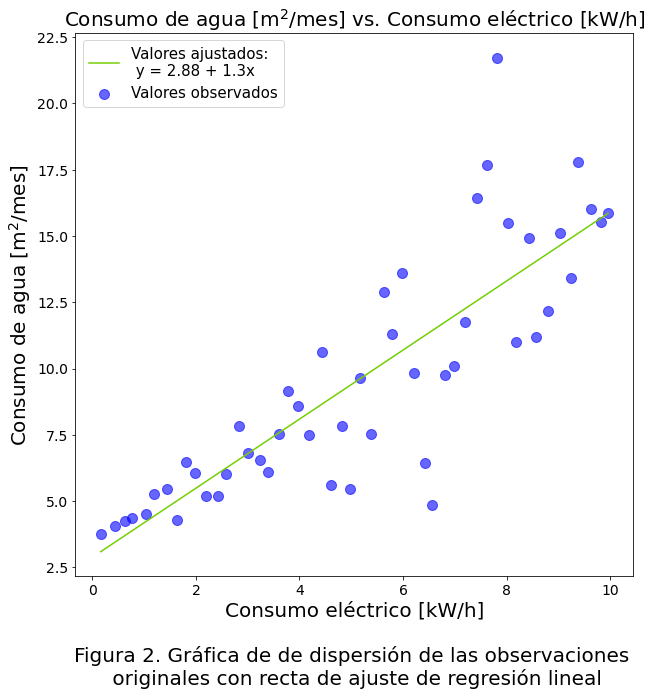

In [7]:
caption = "Figura 2. Gr√°fica de de dispersi√≥n de las observaciones \n originales con recta de ajuste de regresi√≥n lineal"
scatter_fit_plot(df, pretty_columns[0], pretty_columns[1], caption, y_fit = pretty_columns[2], beta_0 = beta_0, beta_1 = beta_1)

In [8]:
working_columns = ["x", "y", "y_fit"]
df.columns = working_columns

_, _, p_value_beta_0 = test_beta_0(df, "x", "y", "y_fit", beta_0)
_, _, p_value_beta_1 = test_beta_1(df, "x", "y", "y_fit", beta_1)
#_, _, p_value_anova = test_analysis_of_variance(df, "y", "y_fit")
R_2 = get_R_2(df, "y", "y_fit")

Significancia del ajuste: 
	 Como el valor p = 1.68e-04 < 0.05 = ùõº, se rechaza la hip√≥tesis nula H_0: ùõΩ_0 = 0 

Significancia del ajuste: 
	 Como el valor p = 1.88e-14 > 0.05 = ùõº, se rechaza la hip√≥tesis nula H_0: ùõΩ_1 = 0 

El valor de R^2 para este ajuste es 0.7087


In [9]:
alpha = 0.1
x_0 = 7.57
CI_lb, CI_ub = prediction_CI(df, "x", "y", "y_fit", x_0, beta_0, beta_1, alpha = alpha)

#CI_lb = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_lb), 4)
#CI_ub = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_ub), 4)

print(f"El valor y_0 ‚àà ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_0 = {x_0}")

El valor y_0 ‚àà (11.975318448398966, 13.510093995011083) con 90.0 % de confianza para x_0 = 7.57


# c) Verifique su modelo via an√°lisis de residuales. Comente.

<Figure size 432x288 with 0 Axes>

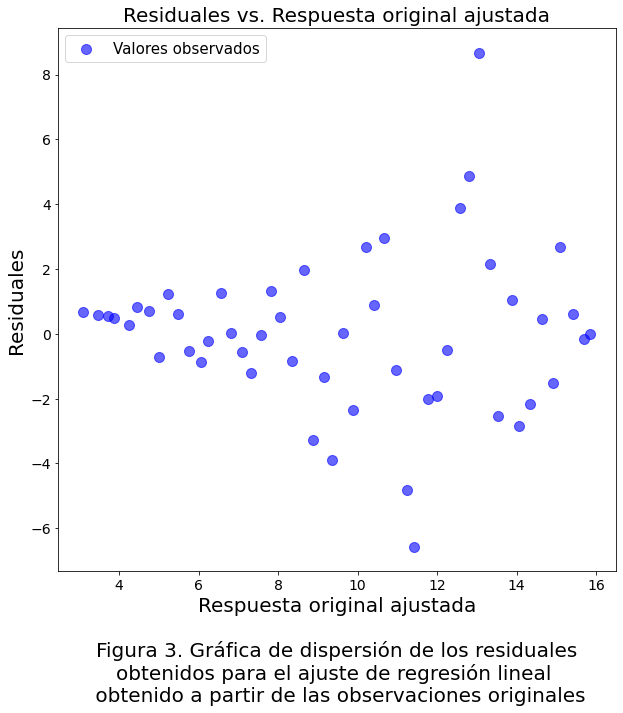

In [10]:
residuales_df = pd.DataFrame(index=df.index, columns=["Respuesta original ajustada", "Residuales"])
residuales_df["Respuesta original ajustada"] = df["y_fit"]
residuales_df["Residuales"] = df["y"] - df["y_fit"]


caption = "Figura 3. Gr√°fica de dispersi√≥n de los residuales\n" +  r"obtenidos para el ajuste de regresi√≥n lineal "+ "\n obtenido a partir de las observaciones originales"
scatter_fit_plot(residuales_df, "Respuesta original ajustada", "Residuales", caption)

In [ ]:
# AGREGAR QQ-PLOT,  ESE ES Figura 4.

In [11]:
beta_0_original = beta_0
beta_1_original = beta_1

# d) Aplique la transformaci√≥n de Box-Cox y construya un intervalo del 90% de confianza para $\lambda$. ¬øQue valor de $\lambda$ elegir√≠a para la trasformaci√≥n? Comente.

Aplicar la transformaci√≥n de Box-Cox a la variable respuesta puede mejorar el ajuste y puede corregir violaciones de los supuestos del modelo de regresi√≥n lineal simple. Un requisito para poder aplicar esta transformaci√≥n es que la variable respuesta conste √∫nicamente de entradas positivas. Para validar que los datos disponibles satisfagan este requisito a continuaci√≥n se cuenta la cantidad de entradas no positivas de la variable respuesta.

In [12]:
working_columns = ["x", "y", "y_fit"]
df.columns = working_columns
count = len(df[df["y"] <= 0].index)
print(f"El n√∫mero de entradas no positivas de la variable respuesta es: {count}")

El n√∫mero de entradas no positivas de la variable respuesta es: 0


La transformaci√≥n de Box-Cox est√° dada por
$$
y^{(\lambda)} = 
\begin{cases}
\frac{y^{\lambda}-1}{\lambda\dot{y}^{\lambda-1}} & \text{si } \lambda \neq 0 \\
\dot{y}\log(y) & \text{si } \lambda = 0 \\
\end{cases}
\quad 
\text{donde}
\quad
\dot{y} = \left(\prod_{i = 1}^n y_i\right)^{\frac{1}{n}}
$$

Para poder aplicar directamente la f√≥rmula de $y^{(\lambda)}$ de la transformaci√≥n de Box-Cox, primero es necesario encontrar un valor √≥ptimo $\hat{\lambda}$. El criterio de optimalidad para el par√°metro $\hat{\lambda}$ es que la suma de los cuadrados de los residuales $SC_{\text{Res}}(\lambda)$ resultante de ajustar el modelo a partir de la respuesta sea m√≠nima; es decir, $\lambda$ est√° dado por

$$
\begin{align}
\hat{\lambda} &= \arg \min_{\lambda \in \mathbb{R}} SC_{\text{Res}}(\lambda)  \\
&= \arg \min_{\lambda \in \mathbb{R}} \sum_{i = 1}^n \left(y_i - y_i^{(\lambda)}\right)^2
\end{align}
$$

En la pr√°ctica, se elige un rango de valores de prueba del par√°metro $\lambda$, se aplica la transfarmaci√≥n de Box-Cox para cada uno de los valores dentro del rango, se ajusta el modelo para cada una de las transformaciones de la respuesta original y se utiliza aqu√©l valor de $\lambda$ con el que se obtenga la suma de cuadrados de los residuales $SC_{\text{Res}}(\lambda)$ m√≠nima.

El resultado de aplicar este procedimiento con $\lambda \in [-1, 1]$ se muestra a continuaci√≥n.

In [15]:
lambda_df = get_lambda(df, "x", "y",  num_l = 41)
pd.options.display.width = 500000
styles = [dict(selector="caption", 
    props=[("text-align", "center"),
    ("font-size", "120%"),
    ("color", 'black')])]
lambda_df = lambda_df.style.set_caption('Tabla X: Estimaci√≥n de $\hat{\lambda}$ para la trasformaci√≥n de Box-Cox').set_table_styles(styles)
#display(lambda_df)


from pandas import option_context

with option_context('display.width', 60000):
    display(lambda_df)

lambda_df.columns = ["$\lambda$", "$SC_{\text{Res}}(\lambda)$", "Clasificaci√≥n"]

De los valores de $\lambda$ dentro del rango seleccionado, se obtiene un valor m√≠nimo de la suma de cuadrados de los residuales $SC_{\text{Res}}(\lambda)$ con $\lambda =$ -0.25. Es importante reslatar que la precisi√≥n de esta estimaci√≥n depende de la cantidad de valores dentro del rango considerado, i.e. entre m√°s fina sea la partici√≥n del intervalo de valores de prueba de $\lambda$, m√°s precisa ser√° la estimaci√≥n de $\hat{\lambda}$.

Aunque probablemente haya un estimador m√°s preciso de $\hat{\lambda}$, utilizar el valor $\lambda =$  -0.25 tiene la ventaja de la interpretaci√≥n de que la transformaci√≥n consiste en tomar el rec√≠proco de la variable respuesta y aplicarle dos veces la funci√≥n ra√≠z cuadrada.

Para ver que $\lambda =$ -0.25 es un valor adecuado para la transformaci√≥n de Box-Cox, a continuaci√≥n se obtiene gr√°ficamente un intervalo de confianza para $\hat{\lambda}$. Para ello, se calcula el valor $SC^*$ dado por

$$SC^* = SC_{\text{Res}}(\hat{\lambda})\left(1 + \frac{t^2_{\left(1-\frac{\alpha}{2},\, n-2\right)}}{n-2}\right)$$

y se utiliza para obtener el intervalo de confianza, que est√° dado por los valores de $\lambda$ para los cuales $SC_{\text{Res}}(\lambda) \geq SC^*$.

In [16]:
def get_CI(lambda_df, n, alpha):
    nu = n-2
    opt_index = lambda_df.index[lambda_df['Clasificaci√≥n'] == "√ìptimo"]
    
    lambda_opt = float(lambda_df.loc[lambda_df.index.isin(opt_index), "$\lambda$"])
    SC_lambda_opt = float(lambda_df.loc[lambda_df.index.isin(opt_index), "$SC_{\text{Res}}(\lambda)$"])
    SS = SC_lambda_opt*(1 + ((stats.t.ppf(1-alpha/2, nu))**2)/(nu))
    
    lambda_df.loc[:, "$SS$"] = SS
    
    intervalo_df = lambda_df[lambda_df["$SC_{\text{Res}}(\lambda)$"] <= SS]
    n_intervalo = len(intervalo_df.index)
    intervalo_lb = float(intervalo_df.loc[intervalo_df.index == intervalo_df.index[0], "$\lambda$"])
    intervalo_ub = float(intervalo_df.loc[intervalo_df.index == intervalo_df.index[n_intervalo-1], "$\lambda$"])
    
    plt.figure()
    plt.figure(figsize=(15,10))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    caption="\n Figura 5: Intervalo de" + f" {100*(1-alpha)} " + r"% de confianza para $\hat{\lambda}$"
    plt.xlabel(r"$\lambda$" + caption,fontsize=20)
    plt.ylabel(r"$SC_{Res}(\lambda)$", fontsize=20)
    plt.title(r"$SC_{Res}(\lambda)$" + " vs. " + r"$\lambda$",fontsize=20)
    plt.axvspan(intervalo_lb, 
                intervalo_ub, 
                alpha=0.05, 
                color='red', 
                label = "Intervalo de confianza")
    plt.plot(lambda_df.loc[:, "$\lambda$"], 
             lambda_df.loc[:, "$SC_{\text{Res}}(\lambda)$"], 
             label = r"$SC_{Res}(\lambda)$")
    plt.plot(lambda_df.loc[:, "$\lambda$"], 
             lambda_df.loc[:, "$SS$"], 
             label = r"Altura $SC^*$" )
    plt.scatter(lambda_opt, 
                SC_lambda_opt, 
                marker = "*",
                color = "red",
                s = 100,
                label = r"$\hat{\lambda}$")
    plt.legend(prop={'size': 15})
    
    plt.show()

In [17]:
lambda_df = get_lambda(df, "x", "y",  num_l = 100)
lambda_df.columns = ["$\lambda$", "$SC_{\text{Res}}(\lambda)$", "Clasificaci√≥n"]

<Figure size 432x288 with 0 Axes>

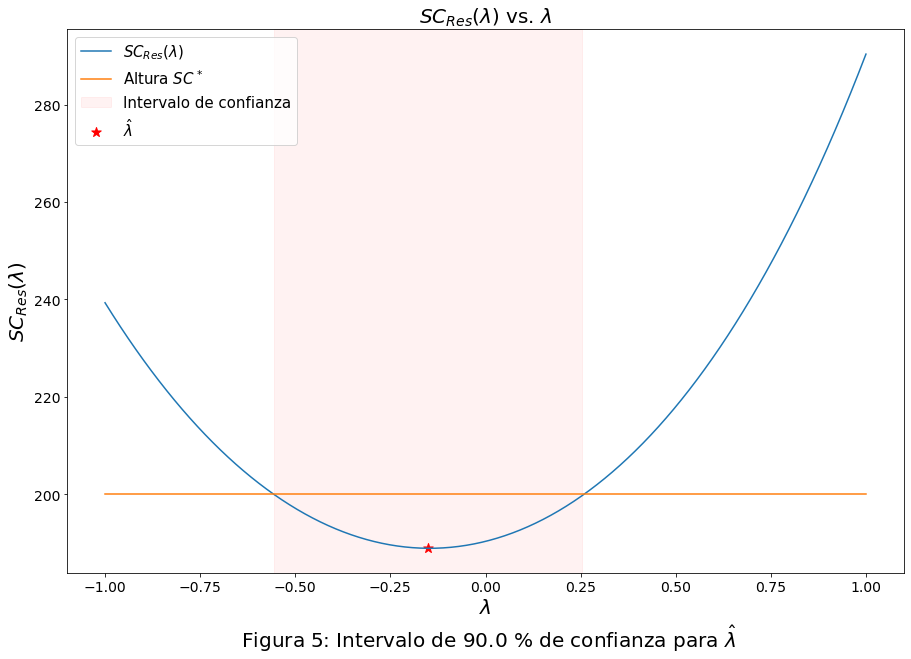

In [18]:
n = len(df.index)
alpha = 0.1
get_CI(lambda_df, n, alpha)

El punto importante a notar en la Figura X es que $\lambda =$  -0.25 se encuentra dentro del intervalo de 90 %  de confianza obtenido para $\hat{\lambda}$.

# e) Grafique $y^{(\lambda)}$ vs. $x$. Comente.

A continuaci√≥n se transforma la variable respuesta utilizando la transformaci√≥n de Box-Cox con $\lambda =$  -0.25 y se grafican los resultados.

In [19]:
working_columns = ["x", "y", "y_fit"]
df.columns = working_columns
l = 0
df["y_trans"] = box_cox_transformation(df, "y", l)

<Figure size 432x288 with 0 Axes>

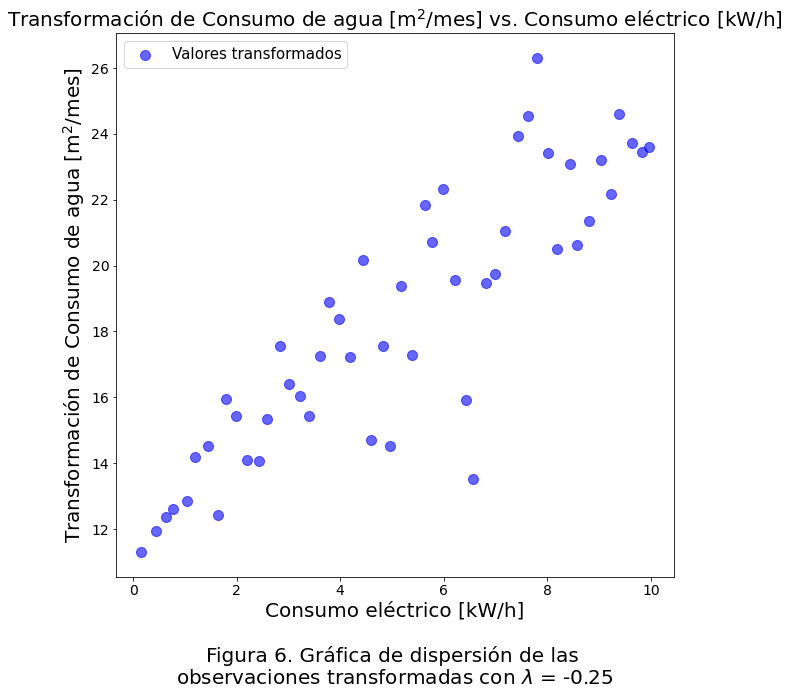

In [20]:
pretty_columns = ["Consumo el√©ctrico [kW/h]", 
                  "Consumo de agua [m$^2$/mes]", 
                  "Ajuste lineal (respuesta original)",
                  "Transformaci√≥n de Consumo de agua [m$^2$/mes]"]
df.columns = pretty_columns

caption = "Figura 6. Gr√°fica de dispersi√≥n de las \n" +  r"observaciones transformadas con $\lambda$ = -0.25"
scatter_fit_plot(df, pretty_columns[0], pretty_columns[3], caption, trans = True)

En la Figura 6. es claro el desvanecimiento de la tendencia de aumento de la tasa de cambio de las observaciones de la variable respuesta con respecto a las observaciones del regresor. De hecho, los datos transformados demuestran una clara relaci√≥n lineal.

# f) Ajuste el modelo correspondiente y val√≠delo. Comente.

En esta secci√≥n se obtiene un ajuste de regresi√≥n lineal a partir de los datos cuya respuesta fue transformada por medio de la transformaci√≥n de Box-Cox con $\lambda = $ -0.25. El ajuste obtenido, as√≠ como los par√°metros de √©ste se encuentran graficados en la Figura 7.

<Figure size 432x288 with 0 Axes>

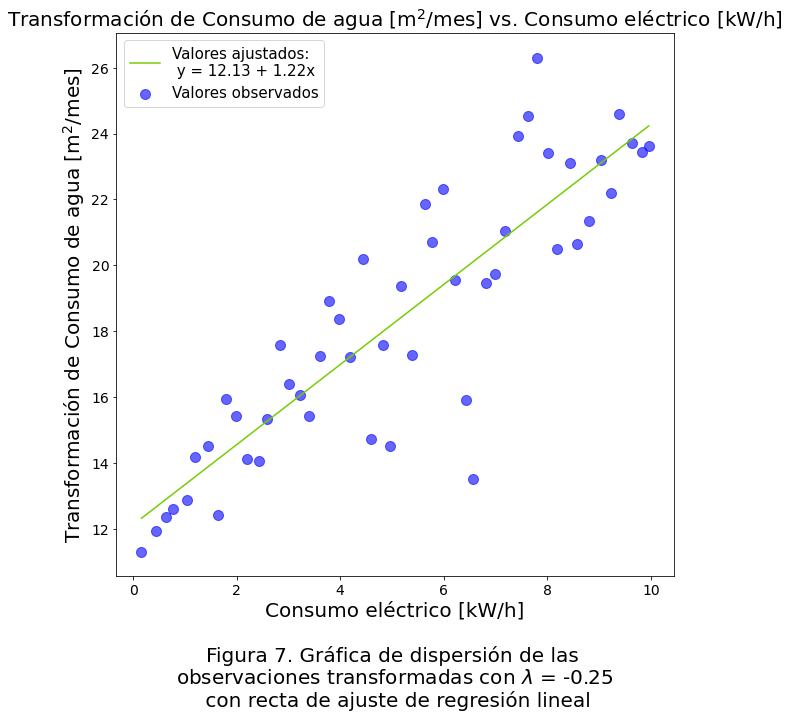

In [21]:
working_columns = ["x", "y", "y_fit", "y_trans"]
df.columns = working_columns

df["y_fit_trans"], beta_0, beta_1 = fit(df, "x", "y_trans")

pretty_columns = ["Consumo el√©ctrico [kW/h]", 
                  "Consumo de agua [m$^2$/mes]", 
                  "Ajuste lineal (respuesta original)",
                  "Transformaci√≥n de Consumo de agua [m$^2$/mes]",
                  "Ajuste lineal (respuesta transformada)"]
df.columns = pretty_columns

caption = "Figura 7. Gr√°fica de dispersi√≥n de las \n" +  r"observaciones transformadas con $\lambda$ = -0.25" + "\n con recta de ajuste de regresi√≥n lineal"
scatter_fit_plot(df, pretty_columns[0], pretty_columns[3], caption, y_fit = pretty_columns[4], beta_0 = beta_0, beta_1 = beta_1)

A continuaci√≥n se realizan las pruebas de hip√≥tesis necesarias para validar la significancia del ajuste obtenido

In [22]:

working_columns = ["x", "y", "y_fit", "y_trans", "y_fit_trans"]
df.columns = working_columns

_, _, p_value_beta_0 = test_beta_0(df, "x", "y_trans", "y_fit_trans", beta_0)
_, _, p_value_beta_1 = test_beta_1(df, "x", "y_trans", "y_fit_trans", beta_1)
#_, _, p_value_anova = test_analysis_of_variance(df, "y_trans", "y_fit_trans")


Significancia del ajuste: 
	 Como el valor p = 0.00e+00 < 0.05 = ùõº, se rechaza la hip√≥tesis nula H_0: ùõΩ_0 = 0 

Significancia del ajuste: 
	 Como el valor p = 0.00e+00 > 0.05 = ùõº, se rechaza la hip√≥tesis nula H_0: ùõΩ_1 = 0 



Entonces, existe evidencia para afirmar que los datos transformados tienen un comportamiento linea.

Tambi√©n es posible evaluar la calidad del ajuste por medio del coeficiente de determinaci√≥n $R^2$ que toma un rango de valores entre 0 y 1.

In [23]:
R_2 = get_R_2(df, "y_trans", "y_fit_trans")

El valor de R^2 para este ajuste es 0.7637


Es importante resaltar que aunque el valor de $R^2$ obtenido para el ajuste de los datos trasformados sea mayor que el correspondiente a los datos originales, estas cantidades no son comparables en realidad debido a la transformaci√≥n aplicada a la variable respuesta.

En la Figura 8. se encuentra la gr√°fica de los residuales determinados a partir del ajuste obtenido por medio de los datos transformados. Es destacable que la tendencia del error a aumentar conforme el incremento de la respuesta ajustada ha desaparecido y que para este caso los residuales aparentan tener una naturaleza m√°s aleatoria que para el caso de los datos originales.

<Figure size 432x288 with 0 Axes>

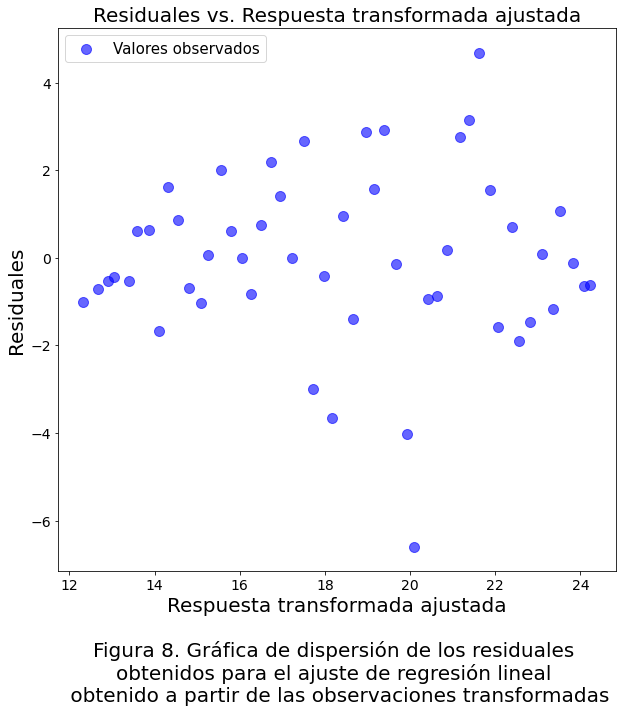

In [24]:
residuales_df = pd.DataFrame(index=df.index, columns=["Respuesta transformada ajustada", "Residuales"])
residuales_df["Respuesta transformada ajustada"] = df["y_fit_trans"]
residuales_df["Residuales"] = df["y_trans"] - df["y_fit_trans"]


caption = "Figura 8. Gr√°fica de dispersi√≥n de los residuales \n" +  r"obtenidos para el ajuste de regresi√≥n lineal "+ "\n obtenido a partir de las observaciones transformadas"
scatter_fit_plot(residuales_df, "Respuesta transformada ajustada", "Residuales", caption)

# g) Construya un intervalo del 90% confianza para el consumo **medio** esperado si el consumo de energ√≠a el√©ctrica es de 7.57 kw/hr. (Nota: el intervalo es para el consumo de agua, no la respuesta transformada.).

Se consideran dos aproximaciones para la obtenci√≥n del intervalo de confianza:
1. Obtenerlo a partir de los par√°metros del ajuste obtenido con los datos originales
2. Obtenerlo a partir de los par√°metros del ajuste obtenido con los datos transformados y aplicarle la transformaci√≥n de Box-Cox inversa para obtener un intervalo en las unidades de los datos originales.

In [25]:
alpha = 0.1
x_0 = 7.57

CI_lb, CI_ub = prediction_CI(df, "x", "y", "y_fit", x_0, beta_0_original, beta_1_original, alpha = alpha)

CI_lb = np.round(CI_lb, 2)
CI_ub = np.round(CI_ub, 2)
print("Intervalo obtenido a partir de los par√°metros del ajuste original:")
print(f"\tEl valor y_0 ‚àà ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_0 = {x_0}")

Intervalo obtenido a partir de los par√°metros del ajuste original:
	El valor y_0 ‚àà (11.98, 13.51) con 90.0 % de confianza para x_0 = 7.57


In [26]:
CI_lb, CI_ub = prediction_CI(df, "x", "y_trans", "y_fit_trans", x_0, beta_0, beta_1, alpha = alpha)

CI_lb = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_lb), 2)
CI_ub = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_ub), 2)
print("Intervalo obtenido a partir de los par√°metros del ajuste transformado:")
print(f"\tEl valor y_0 ‚àà ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_bar = {x_0}")

Intervalo obtenido a partir de los par√°metros del ajuste transformado:
	El valor y_0 ‚àà (5.75, 6.58) con 90.0 % de confianza para x_bar = 7.57


# h) Construya un intervalo de predicci√≥n de 95 % para la demanda esperada si la generaci√≥n de energ√≠a es de 5.1 kw/hr.

Nuevamente, se consideran las dos aproximaciones del inciso anterior.

In [27]:
alpha = 0.05
x_0 = 5.1

CI_lb, CI_ub = prediction_CI(df, "x", "y", "y_fit", x_0, beta_0_original, beta_1_original, alpha = alpha, mean = False)

CI_lb = np.round(CI_lb, 2)
CI_ub = np.round(CI_ub, 2)
print("Intervalo obtenido a partir de los par√°metros del ajuste original:")
print(f"\tEl valor y_0 ‚àà ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_0 = {x_0}")

Intervalo obtenido a partir de los par√°metros del ajuste original:
	El valor y_0 ‚àà (4.53, 14.52) con 95.0 % de confianza para x_0 = 5.1


In [28]:
CI_lb, CI_ub = prediction_CI(df, "x", "y_trans", "y_fit_trans", x_0, beta_0, beta_1, alpha = alpha, mean = False)

CI_lb = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_lb), 2)
CI_ub = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_ub), 2)
print("Intervalo obtenido a partir de los par√°metros del ajuste transformado:")
print(f"\nEl valor y_0 ‚àà ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_0 = {x_0}")

Intervalo obtenido a partir de los par√°metros del ajuste transformado:

El valor y_0 ‚àà (3.07, 6.89) con 95.0 % de confianza para x_0 = 5.1


# Conclusiones

A pesar de que el ajuste de regresi√≥n lineal obtenido a partir de los datos originales tuviera una apariencia adecuada, no era un ajuste v√°lido debido a que los datos no satisfac√≠an los supuestos del modelo.

Por medio de la transformaci√≥n de Box-Cox fue posible corregir la desviaci√≥n de los datos de manera que los supuestos del modelo de regresi√≥n lineal se cumplieran y se obtuvo un ajuste mucho m√°s satisfactorio.

Ambos ajustes se utilizaron para realizar inferencias de valores de la variable respuesta a partir de valores dados del regresor.